In [5]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Two clusters: {A,B,C} and {D,E,F}
nodes = ["A", "B", "C", "D", "E", "F"]
cluster1 = {"A", "B", "C"}   # red
cluster2 = {"D", "E", "F"}   # white

# Mostly intra-cluster edges + one bridge edge to allow mixing
edges = [
    ("A","B"), ("B","C"), ("A","C"),    # cluster 1
    ("D","E"), ("E","F"), ("D","F"),    # cluster 2
    ("C","D")                           # bridge
]

# Map nodes to indices
node_to_idx = {n:i for i,n in enumerate(nodes)}
idx_to_node = {i:n for n,i in node_to_idx.items()}

# edge_index [2, E] undirected
edge_index = torch.tensor([[node_to_idx[u], node_to_idx[v]] for u,v in edges], dtype=torch.long).t()
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # add reverse

N = len(nodes)

# Initial colors (RGB in [0,1])
red   = torch.tensor([1.0, 0.0, 0.0])
white = torch.tensor([1.0, 1.0, 1.0])

x0 = torch.stack([red if n in cluster1 else white for n in nodes], dim=0)  # [N,3]


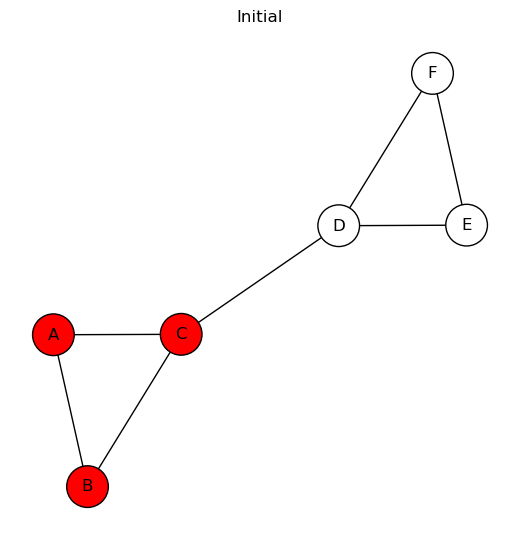

In [ ]:
def plot_graph_colors(nodes, edges, x_rgb, title=""):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    pos = nx.spring_layout(G, seed=0)

    # convert tensor colors to RGBA list for nx.draw
    colors = x_rgb.clamp(0,1).detach().cpu().numpy()
    colors_rgba = [(*c, 1.0) for c in colors]

    plt.figure(figsize=(5,5))
    nx.draw(G, pos, with_labels=True, node_color=colors_rgba, edgecolors="black", node_size=900)
    plt.title(title)
    plt.axis("off")
    plt.show()

def neighbor_mean_agg(edge_index, x, num_nodes):
    src, dst = edge_index
    out = torch.zeros_like(x)
    deg = torch.zeros(num_nodes, device=x.device, dtype=x.dtype)

    out.index_add_(0, dst, x[src])
    deg.index_add_(0, dst, torch.ones_like(dst, dtype=x.dtype))

    out = out / deg.clamp(min=1).unsqueeze(1)
    return out

def neighbor_gcn_agg(edge_index, x, num_nodes):
    src, dst = edge_index

    deg = torch.zeros(num_nodes, device=x.device, dtype=x.dtype)
    deg.index_add_(0, dst, torch.ones_like(dst, dtype=x.dtype))

    deg_inv_sqrt = deg.clamp(min=1).pow(-0.5)
    norm = deg_inv_sqrt[src] * deg_inv_sqrt[dst]  # [E]

    out = torch.zeros_like(x)
    out.index_add_(0, dst, x[src] * norm.unsqueeze(1))
    return out

def blend_step(edge_index, x, alpha=0.1, mode="mean"):
    num_nodes = x.size(0)
    if mode == "mean":
        neigh = neighbor_mean_agg(edge_index, x, num_nodes)
    elif mode == "gcn":
        neigh = neighbor_gcn_agg(edge_index, x, num_nodes)
    else:
        raise ValueError("mode must be 'mean' or 'gcn'")

    # small update towards neighbor-aggregate color
    x_new = (1 - alpha) * x + alpha * neigh
    return x_new.clamp(0, 1)

def blend_step(edge_index, x, alpha=0.1, mode="mean"):
    num_nodes = x.size(0)
    if mode == "mean":
        neigh = neighbor_mean_agg(edge_index, x, num_nodes)
    elif mode == "gcn":
        neigh = neighbor_gcn_agg(edge_index, x, num_nodes)
    else:
        raise ValueError("mode must be 'mean' or 'gcn'")

    # small update towards neighbor-aggregate color
    x_new = (1 - alpha) * x + alpha * neigh
    return x_new.clamp(0, 1)

plot_graph_colors(nodes, edges, x0, "Initial")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
from IPython.display import HTML, display

# --- precompute graph + layout once ---
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G, seed=0)

# --- precompute states (fast, correct) ---
alpha = 0.15
mode = "mean"
steps = list(range(0, 201, 10))  # frames displayed

x_states = []
x = x0.clone()
x_states.append(x.clone())
for _ in range(1, max(steps) + 1):
    x = blend_step(edge_index, x, alpha=alpha, mode=mode)
    x_states.append(x.clone())

# --- setup figure once ---
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis("off")

# initial draw
colors0 = x_states[0].clamp(0, 1).cpu().numpy()
colors_rgba0 = [(*c, 1.0) for c in colors0]

# draw nodes/edges once
nx.draw_networkx_edges(G, pos, ax=ax, edge_color="grey", width=1.0, alpha=0.6)
node_coll = nx.draw_networkx_nodes(
    G, pos, ax=ax,
    node_color=colors_rgba0,
    edgecolors="black",
    node_size=900,
)
nx.draw_networkx_labels(G, pos, ax=ax)

title = ax.set_title("Step 0")

def update(frame_idx):
    step = steps[frame_idx]
    colors = x_states[step].clamp(0, 1).cpu().numpy()
    colors_rgba = np.concatenate([colors, np.ones((colors.shape[0], 1))], axis=1)  # [N,4]
    node_coll.set_facecolor(colors_rgba)
    title.set_text(f"Step {step}")
    return node_coll, title

anim = animation.FuncAnimation(
    fig, update,
    frames=len(steps),
    interval=500,
    blit=False,   # safer with networkx artists
    repeat=True
)

plt.close(fig)
display(HTML(anim.to_html5_video()))


In [16]:
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display

def k_hop_sets_from_edge_index(edge_index, num_nodes, seed_nodes, K):
    """
    Returns:
      included[k]  = set of nodes within <=k hops
      frontier[k]  = set of nodes at exactly k hops
    """
    if torch.is_tensor(edge_index):
        edge_index = edge_index.cpu().numpy()
    src, dst = edge_index
    adj = [[] for _ in range(num_nodes)]
    for u, v in zip(src, dst):
        adj[u].append(v)

    seed_nodes = set(seed_nodes)
    included = [set() for _ in range(K + 1)]
    frontier = [set() for _ in range(K + 1)]

    included[0] = set(seed_nodes)
    frontier[0] = set(seed_nodes)

    for k in range(1, K + 1):
        nbrs = set()
        for u in frontier[k - 1]:
            nbrs.update(adj[u])
        # "exactly k hops" are new nodes not seen before
        frontier[k] = nbrs - included[k - 1]
        included[k] = included[k - 1] | frontier[k]

    return included, frontier

# ---- choose your seed(s) ----
seed_name = "A"                    # change this
seed = [node_to_idx[seed_name]]    # or multiple seeds: [node_to_idx["A"], node_to_idx["D"]]
K = 4                              # number of hops to show

# Build the NetworkX graph once (use your existing nodes/edges)
G = nx.Graph()
G.add_nodes_from(range(len(nodes)))
G.add_edges_from([(node_to_idx[u], node_to_idx[v]) for u, v in edges])

pos = nx.spring_layout(G, seed=0)  # compute once

included, frontier = k_hop_sets_from_edge_index(edge_index, num_nodes=len(nodes), seed_nodes=seed, K=K)

# ---- plotting setup once ----
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis("off")

# draw edges once
nx.draw_networkx_edges(G, pos, ax=ax, edge_color="lightgrey", width=1.0, alpha=0.7)

# draw labels once (map indices -> names)
labels = {node_to_idx[n]: n for n in nodes}
nx.draw_networkx_labels(G, pos, labels=labels, ax=ax)

# initial node colors
def colors_for_step(k):
    # color scheme (RGBA)
    c_not = (0.85, 0.85, 0.85, 1.0)  # not included yet (grey)
    c_in  = (1.00, 1.00, 1.00, 1.0)  # already included (white)
    c_new = (1.00, 0.25, 0.25, 1.0)  # newly added frontier (red-ish)
    c_seed= (0.10, 0.10, 0.10, 1.0)  # seed (black)

    colors = []
    for i in range(len(nodes)):
        if i in seed:
            colors.append(c_seed)
        elif i in frontier[k]:
            colors.append(c_new)
        elif i in included[k]:
            colors.append(c_in)
        else:
            colors.append(c_not)
    return colors

node_coll = nx.draw_networkx_nodes(
    G, pos, ax=ax,
    node_color=colors_for_step(0),
    edgecolors="black",
    node_size=900
)

title = ax.set_title(f"Seed: {seed_name} | Hop 0 (frontier: {sorted(frontier[0])})")

def update(frame_k):
    node_coll.set_facecolor(colors_for_step(frame_k))
    title.set_text(f"Seed: {seed_name} | Hop {frame_k} | +{len(frontier[frame_k])} new nodes")
    return node_coll, title

anim = animation.FuncAnimation(
    fig, update,
    frames=range(0, K + 1),
    interval=900,
    blit=False,
    repeat=True
)

plt.close(fig)
display(HTML(anim.to_html5_video()))


### Message Passing and Normalization

Aggregates the incoming node embeddings for each node in the graph.

Normalizes the message being passed between neighbors using the inverse square root of the connection degree for the source * the destination nodes. 

In [8]:
# Get the RGB values as a tensor
rgb = torch.tensor(node_colors, dtype=torch.float)[:, :3]
src, dst = edge_index
N = rgb.size(0)

def gcn_norm_from_node_degree(src, dst, N, rgb):
    deg = torch.zeros(N, dtype=rgb.dtype, device=rgb.device)
    deg.index_add_(0, dst, torch.ones_like(dst, dtype=rgb.dtype, device=rgb.device))
     
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[torch.isinf(deg_inv_sqrt)] = 0.0
    
    norm = deg_inv_sqrt[src] * deg_inv_sqrt[dst]  # [E]
     
    return norm

# Linear transformation
W = torch.nn.Linear(3, 3, bias=False)

# Pass the colors through the linear layer
x = W(rgb)

norm = gcn_norm_from_node_degree(src, dst, N, x)

# Normalize the messages based on connected node degrees
messages = x[src] * norm.unsqueeze(1)

# Aggregate normalized messages at destination nodes
agg = torch.zeros_like(x)
agg.index_add_(0, dst, messages)

# Apply non-linearity function to the message
out = torch.relu(agg)

print("out:", out)

IndexError: index out of range in self

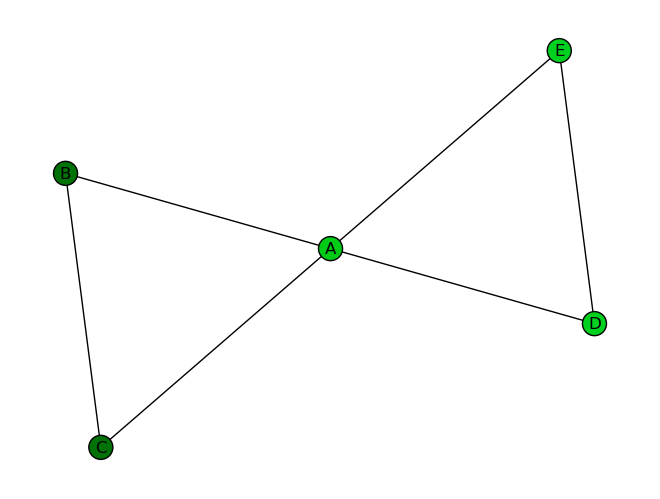

In [ ]:
plot_graph(nodes, edges, out.detach().numpy())

### Final linear transform after message passing and aggregation

In [ ]:
W = torch.nn.Linear(F, F, bias=False)
out = W(aggregated_messages)

NameError: name 'F' is not defined

In [ ]:
new_node_colors = []
print(node_colors)
for i, node in enumerate(node_colors):
    node_list = list(node)
    for j in range(3):
        node_list[j] = float(np.clip(node_list[j] + out[i][j].item(), 0.0, 1.0))
    new_node_colors.append(tuple(node_list))

print(new_node_colors)
    

[(1.0, 1.0, 1.0, 1.0), (1.0, 0.0, 0.0, 1.0), (1.0, 0.0, 0.0, 1.0), (1.0, 1.0, 1.0, 1.0), (1.0, 1.0, 1.0, 1.0)]
[(1.0, 1.0, 1.0, 1.0), (1.0, 0.06996084004640579, 0.10380854457616806, 1.0), (1.0, 0.06996084004640579, 0.10380854457616806, 1.0), (1.0, 1.0, 1.0, 1.0), (1.0, 1.0, 1.0, 1.0)]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

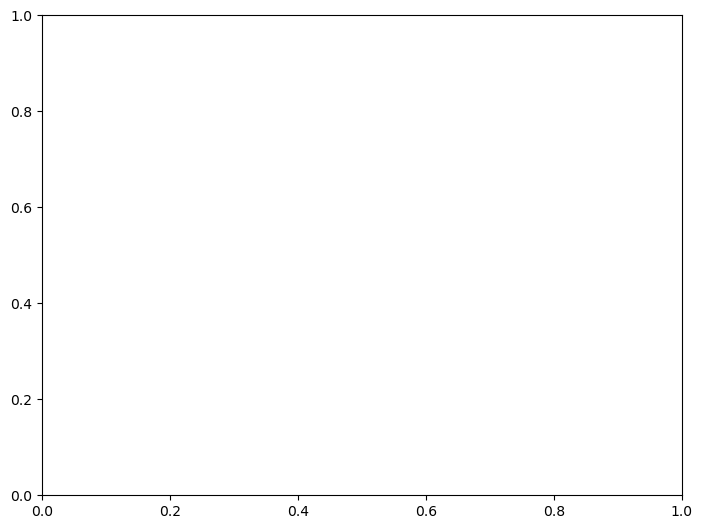

In [ ]:
# Visualize the graph with new node colors and edge strengths
plot_graph(nodes, edges, new_colors)

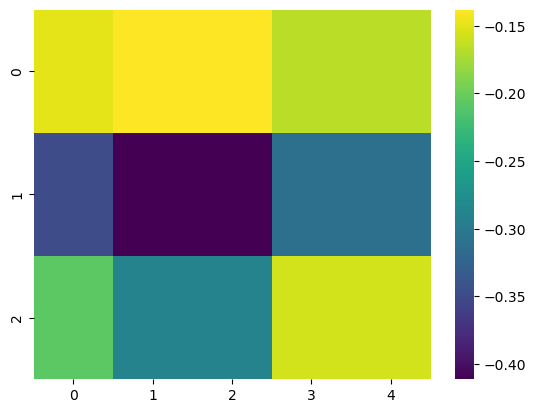

In [ ]:
sns.heatmap(node_embedding.detach().numpy().T, cmap="viridis")
plt.show()